# Predicting Clutch Goalscorers in the NHL using Machine Learning Techniques

This project applies machine learning techniques to identify and predict NHL forwards who excel in “clutch” situations (close, tied, and overtime games). The goal is not only to measure  clutch performance but to model expected clutch scoring given a player’s underlying metrics.

### 1. Data Sources
* NHL API: Player biographical information and traditional goal statistics
* Natural Stat Trick:
  - Goals scored in tied, one-goal deficit, and overtime situations
  - Advanced performance metrics (scoring chances, assists, ice time, rebounds)

### 2. Establishing a Definition of Clutch
I computed a "clutch score" for each player by weighting their goals in critical game situations:

- Goals per game when the game is tied (40% weight)
- Goals per game when the team is down by one goal (40% weight)
- Goals per game in overtime (20% weight)

### 3. Building a Classification Model
I first tried classification since it seemed logical to classify players as "clutch" and "non-clutch". I set thresholds for the clutch score and trained an XGBoost model on data from the 2020-2021 to the 2023-2024 NHL season. The model used various underlying performance metrics such as expected goals, high-danger scoring chances, shot attempts. While the model was successful in identifying elite players and those below average, it struggled with players who fell near the classification boundaries, where small differences in their stats made it difficult to confidently label them as clutch or non-clutch. 

### 4. Switching to a Regression Model
Linear regression was a more feasible approach since many of the features were strongly correlated with a clutch score. It would be easier to predict a player's clutch score rather than assigning the player an ambiguous label.  

However, there was multicollinearity among features, which would lead to instability in coefficients and make it difficult to interpret the impact of features on the clutch score. Therefore, a small subset of features were kept (scoring chances, assists, time on ice, rebounds created). 

I also refined the model by using Ridge regression and performed cross-validation to ensure there was less overfitting.

### 5. Dealing with Outliers
I used Cook's distance to identify influential points. The model underpredicted the clutch score of elite players because their feature stats set a "ceiling" for their clutch ability. The model also overestimated some elite players who had strong underlying metrics but did not perform well in clutch games. In addition, the model struggled with below-average players who scored clutch goals at a rate that did not match their advanced stats.  This prompted me to use a log transformation on the clutch score, which enabled the model to generate better predictions for elite players and reduced the number of influential points. 

After the transformation, the model still undervalued some players who performed better in close and tied situations than their metrics suggest. While influential points are often viewed negatively, they can show which players perform better under pressure than their stats suggest. 

### 6. Prediction Intervals
95% prediction intervals were generated for each player. If actual clutch scores fall outside the intervals, this indicates that clutch performance is significantly different from expectations.

### 7. Shap Values
SHAP values were calculated to explain which features most influenced each player's prediction.

### 8. Using the Model on a Final Test Set
The model was tested on player data from the 2024-2025 season to the current point of the 2025-2026 season. The R² of 70% indicates the model explains 70% of variance in clutch performance, which is strong given the inherent randomness in clutch situations. 


### Imports
These are the necessary imports for the project.

In [184]:
# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General imports
import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# XGBoost and machine learning
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA

# Hyperparameter tuning with Skopt
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Saving Model
import joblib

### NHL API
The following snippet of code scrapes data from the NHL API for the 2020-2021 to 2022-2023 NHL seasons, while accounting for any issues that may occur when connecting to the API. It also combines a player's stats across these seasons.

In [186]:
all_seasons = []

for season in range(2020, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
print(nhl_api_df)

Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009        Zdeno Chara            D          127       20        0   
1      8466138       Joe Thornton            C           78       20        0   
2      8466139    Patrick Marleau            C           56        5        0   
3      8469455       Jason Spezza            C          125       33        0   
4      8469459        Mikko Koivu            C            7        1        0   
...        ...                ...          ...          ...      ...      ...   
1346   8484314       Jiri Smejkal            L           20        1        0   
1347   8484321  Nikolas Matinpalo            D            4        0        0   
1348   8484325    Waltteri Merela            C           19        0        0   
13

### Cleaning the Scraped NHL API Data
The next step is to clean the data properly:
-  Only forwards are included since defensemen score at different rates. 
-  I kept players who appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.
-  Finally, some columns are renamed to maintain a consistent naming format.

In [188]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 100)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)


### Scraping Data from Natural Stat Trick
The code below establishes URL links for the pages needed from Natural Stat Trick.

In [190]:
start_season = "20202021"
end_season = "20232024"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

### Scraping Data from Natural Stat Trick
The code below scrapes data from Natural Stat Trick and stores the data for each page in a dataframe.

In [192]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

### Cleaning Data from Natural Stat Trick
After scraping the data from Natural Stat Trick, only relevant columns are included for each dataframe. These dataframes are then merged into one dataframe containing all statistics from Natural Stat Trick.

Similar to the NHL API data, only players who have played at least 60 games are included.

The dataframes do not need to be filtered for forwards because it was easier to do this through the URLs.


In [738]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF', 'iMDCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 100]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

KeyError: "['iMDCF'] not in index"

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [196]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [197]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
2,Jason Spezza,125,3,4,7,22,178,17.16,243,155,66,24,313
6,Eric Staal,125,3,2,8,19,188,21.77,253,206,106,28,328
7,Jeff Carter,209,10,11,11,49,493,51.65,618,450,236,89,781
8,Dustin Brown,113,5,5,6,26,275,30.32,364,241,122,22,445
9,Zach Parise,209,5,6,15,43,410,54.32,523,438,261,60,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,Dawson Mercer,164,10,8,10,44,315,42.95,409,365,194,45,521
716,Anton Lundell,138,4,4,9,30,277,30.49,367,281,118,38,484
717,Tim Stützle,210,14,8,24,73,516,61.43,707,609,232,74,943
733,Alexander Barabanov,160,3,8,12,28,246,31.15,334,307,165,40,425


In [198]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game
0,8469455,Jason Spezza,C,125,33,0,653.259850
1,8470595,Eric Staal,C,125,23,1,868.724300
2,8470604,Jeff Carter,C,281,59,2,907.693300
3,8470606,Dustin Brown,R,113,33,0,970.804500
4,8470610,Zach Parise,L,239,49,1,875.162550
...,...,...,...,...,...,...,...
457,8482705,Cole Sillinger,C,220,42,0,862.584500
458,8482740,Wyatt Johnston,C,164,50,0,974.524350
459,8482745,Mason McTavish,C,153,50,1,894.595667
460,8483515,Juraj Slafkovský,L,121,36,0,904.534650


### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [200]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals = merged_clutch_goals.dropna()

In [201]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,time_on_ice_per_game,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rebounds_created,iCF
0,8469455,Jason Spezza,C,125,33,0,653.259850,125.0,3.0,4.0,7.0,22.0,178.0,17.16,243.0,155.0,66.0,24.0,313.0
1,8470595,Eric Staal,C,125,23,1,868.724300,125.0,3.0,2.0,8.0,19.0,188.0,21.77,253.0,206.0,106.0,28.0,328.0
2,8470604,Jeff Carter,C,281,59,2,907.693300,209.0,10.0,11.0,11.0,49.0,493.0,51.65,618.0,450.0,236.0,89.0,781.0
3,8470606,Dustin Brown,R,113,33,0,970.804500,113.0,5.0,5.0,6.0,26.0,275.0,30.32,364.0,241.0,122.0,22.0,445.0
4,8470610,Zach Parise,L,239,49,1,875.162550,209.0,5.0,6.0,15.0,43.0,410.0,54.32,523.0,438.0,261.0,60.0,599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,8482110,Dawson Mercer,C,246,67,1,1006.382067,164.0,10.0,8.0,10.0,44.0,315.0,42.95,409.0,365.0,194.0,45.0,521.0
445,8482113,Anton Lundell,C,216,69,1,949.680133,138.0,4.0,4.0,9.0,30.0,277.0,30.49,367.0,281.0,118.0,38.0,484.0
446,8482116,Tim Stützle,C,285,156,4,1148.016200,210.0,14.0,8.0,24.0,73.0,516.0,61.43,707.0,609.0,232.0,74.0,943.0
452,8482222,Alexander Barabanov,L,206,75,1,951.277225,160.0,3.0,8.0,12.0,28.0,246.0,31.15,334.0,307.0,165.0,40.0,425.0


### Changing Columns
Drop the "GP" column since it existed in both previously merged dataframes.

Compute per game stats to accurately compare players.

In [203]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from the rtiaio55nal v5.


In [205]:
merged_clutch_goals['clutch_score'] = (
    0.4 * merged_clutch_goals['goals_when_tied_per_game'] + 
    0.4 * merged_clutch_goals['goals_down_by_one_per_game'] + 
    0.2 * merged_clutch_goals['ot_goals_per_game']
)

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [207]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
308,Auston Matthews,10.64,1.0
232,David Pastrnak,9.79,2.0
296,Kirill Kaprizov,9.64,3.0
261,Connor McDavid,9.59,4.0
218,Leon Draisaitl,9.16,5.0
128,Gabriel Landeskog,8.57,6.0
224,Jakub Vrana,8.52,7.0
367,Jason Robertson,8.30,8.0
220,William Nylander,8.24,9.0
332,Tage Thompson,8.00,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


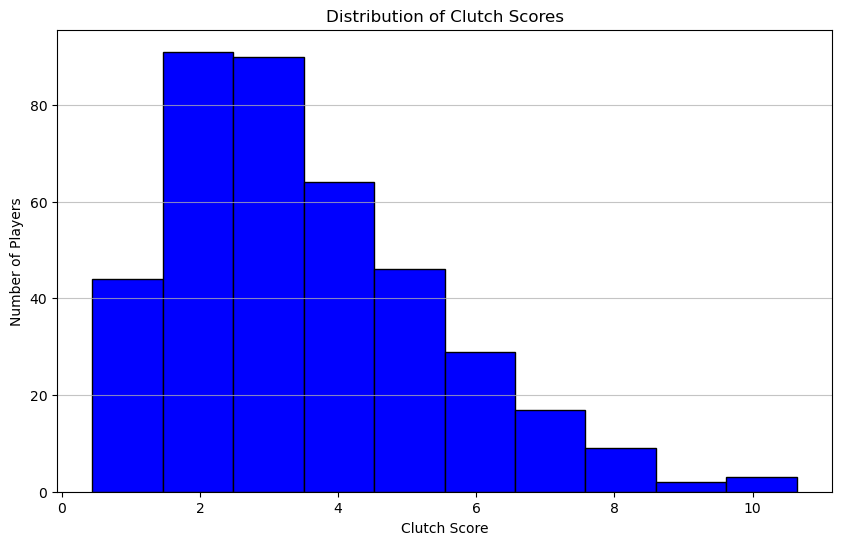

In [209]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [211]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [213]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    335
1     60
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was not idlea.


### Starting with XGBoost

XGBoost builds an ensemble of decision trees by correcting the prediction errors of previous trees.

Many statistics relevant to a player's goalscoring (e.g. shooting, assists, ice time) are used as features. The model is then trained on an 80-20 split of the data. The **stratify = y** parameter ensures that the training and testing sets have the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers). Therefore, the minority class (clutch goalscorers) will not be underrepresented.

The model uses the log loss evaluation metric, which measures the difference between the true class labels (0 or 1) and the predicted probabilities fir the positive class. A greater difference between the predicted probabilities and the actual labels results in a higher log loss. 

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [216]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Initial Evaluation of the Model

The XGBoost model is evaluated using StratifiedKFold cross-validation with 10 splits. Four metrics are used to assess the model's performance: accuracy, precision, recall, and F1 score.

With 10-fold cross-validation, the dataset is divided into 10 groups. We train the model on 10 - 1 = 9 groups and test the model (evaluate its metrics) on the remaining group. This process is repeated 10 times to ensure every group serves as a test set. The metrics are then average across the 10 folds.

As with stratify = y, each fold has the same class distribution as the original dataset (i.e. same representation of the number of clutch and non-clutch goalscorers).

### Definitions of Metrics

Accuracy: The proportion of correct predictions among the total number of predictions.

Precision: The proportion of true positives among all instances predicted as positive. It answers the question: "When we predicted positive (a player classified as clutch), how many times were we correct?"

Recall: The proportion of true positives among all actual positives. It answers the question: "Of all the actual positives (clutch goalscorers), how many did the model correctly identify?"

F1 Score: The harmonic mean of precision and recall. Taking the harmonic mean ensures the F1 Score is not skewed by extreme values of precision and recall.

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [220]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.065644
score_time        0.011961
test_accuracy     0.876474
test_precision    0.793917
test_recall       0.633333
test_f1           0.612051
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation
Note: The high imbalance in the dataset means that stratified cross-validation may not be able to create balanced splits, leading to the error message.


C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Work\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Work\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of 

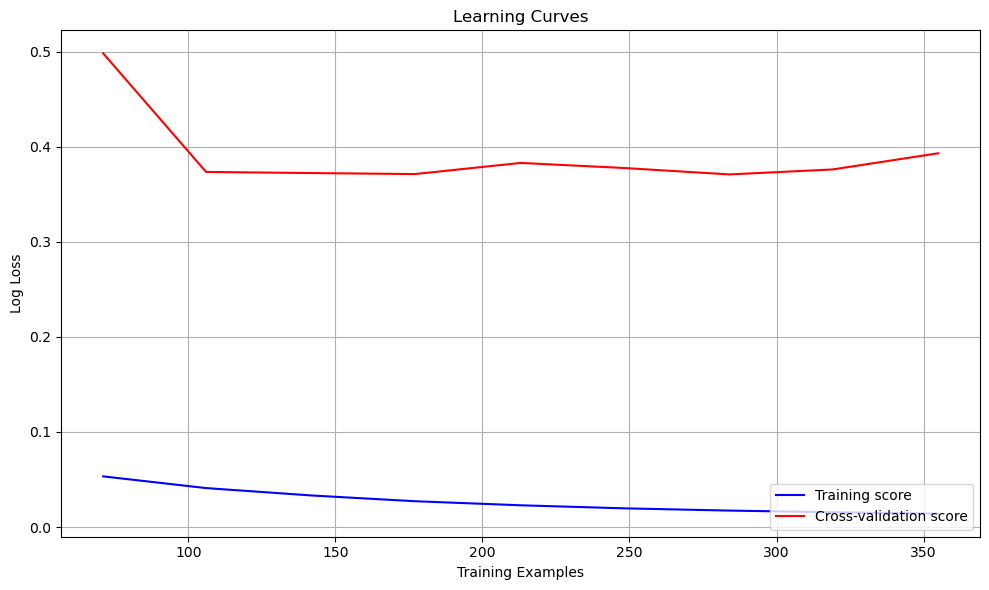

In [222]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance
Feature importance helps us to determine which features the model relies on during training and remove less influential features. This enables the model to focus on the most relevant information when training and improve its ability to generalize to unseen data.

The F score (Feature Importance score) reflects how frequently a feature contributes to the decision-making process in the model. For gradient boosting models, importance is based on the improvement in the loss function when a feature is used to split the data within the trees.


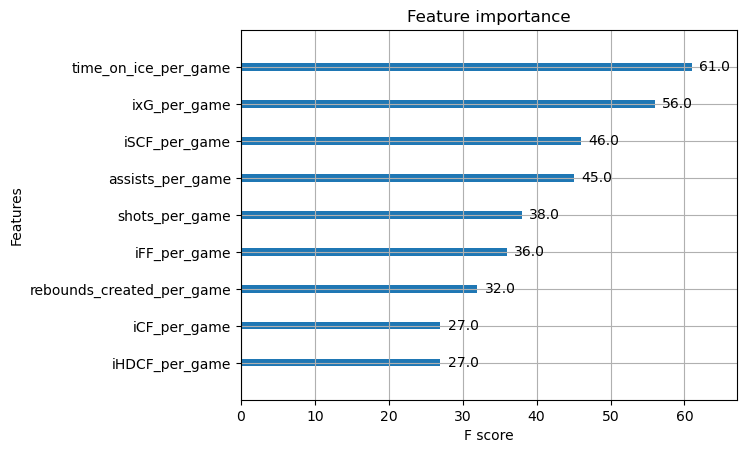

In [224]:
plot_importance(xgb_model)
plt.show()

### Obtaining the Most Important Features
The following lines of code obtain all features with an F score greater than 40.

In [226]:
importance = xgb_model.get_booster().get_score(importance_type='weight')
important_features = {}

for feature, score in importance.items():
    if score >= 40:
        important_features[feature] = score

important_feature_names = list(important_features.keys())

X_adjusted = merged_clutch_goals[important_feature_names]  


### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model:

- **max_depth:** This controls the maximum depths of the trees. Although a greater depth allows the model to capture more intricate patterns in the data, it can start memorizing patterns in the data and overfit.

- **min_child_weight:** As each node is split based on a condition, data is passed down to nodes. min_child_weight is the minimum number of samples that a node must hold before it is split further. If there are less than min_child_weight samples at that node, the node will not be split further. This means that the node becomes a leaf.

    A higher min_child_weight means that a split will only occur if there is enough data and the model will not overfit to small non-representative samples of the data.

- **n_estimators:** n_estimators represents the number of trees that the model will use during training. As with depth, a higher number of trees can help the model identify more complex patterns in the data. However, the model can become too complex and may start memorizing the data. This will lead to overfitting.

- **learning_rate:** learning_rate controls how much each tree's contribution is scaled during training.
  
    A lower learning rate means that each tree's contribution is smaller, and the model will make smaller adjustments after adding a new tree. This can help the model generalize the data, but may also require more trees, thus leading to overfitting.

    A higher learning rate means each tree's contribution is larger and the model will make larger adjustments after adding a new tree. This can lead to a faster solution but cause the model to miss important details in the data and overfit.

- **reg_alpha:** This parameter helps to reduce the number of features considered in splits. If a feature has no or little contribution in splits, reg_alpha pushes its weight to 0. This enables the model to focus on important features and leads to better generalization.

- **reg_lamda:** reg_lamda adds a penalty to the squared values of the feature weights that are have no or little contribution in splits. This discourages large weights but does not force weights to zero, unlike reg_alpha. This leads to better generalization without necessarily eliminating features.

- **subsample:** subsample controls the fraction of data that is randomly sampled for training in each tree. By limiting the amount of training data, subsample prevents the model from memorizing details in the data and leads to less overfitting.

- **colsample_bytree :** This parameter controls the fraction of features that are randomly sampled for each tree. Since colsample_bytree limits the number of features used in each tree, it prevent the model from becoming overly dependent on any single feature and leads to better generalization.


In [228]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search
Random search is a hyperparameter tuning technique that randomly samples hyperparameter combinations from the parameter grid. The model is then trained and evaluated using k-Fold cross-validation on k - 1 subsets of the training data. The cross-validation score (in this case, F1 score) is calculated for the test fold, and the average score across all k iterations is used to evaluate the performance of that particular set of hyperparameters. This method helps to find a good set of hyperparameters without exhaustively testing every possible combination, unlike grid search.

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


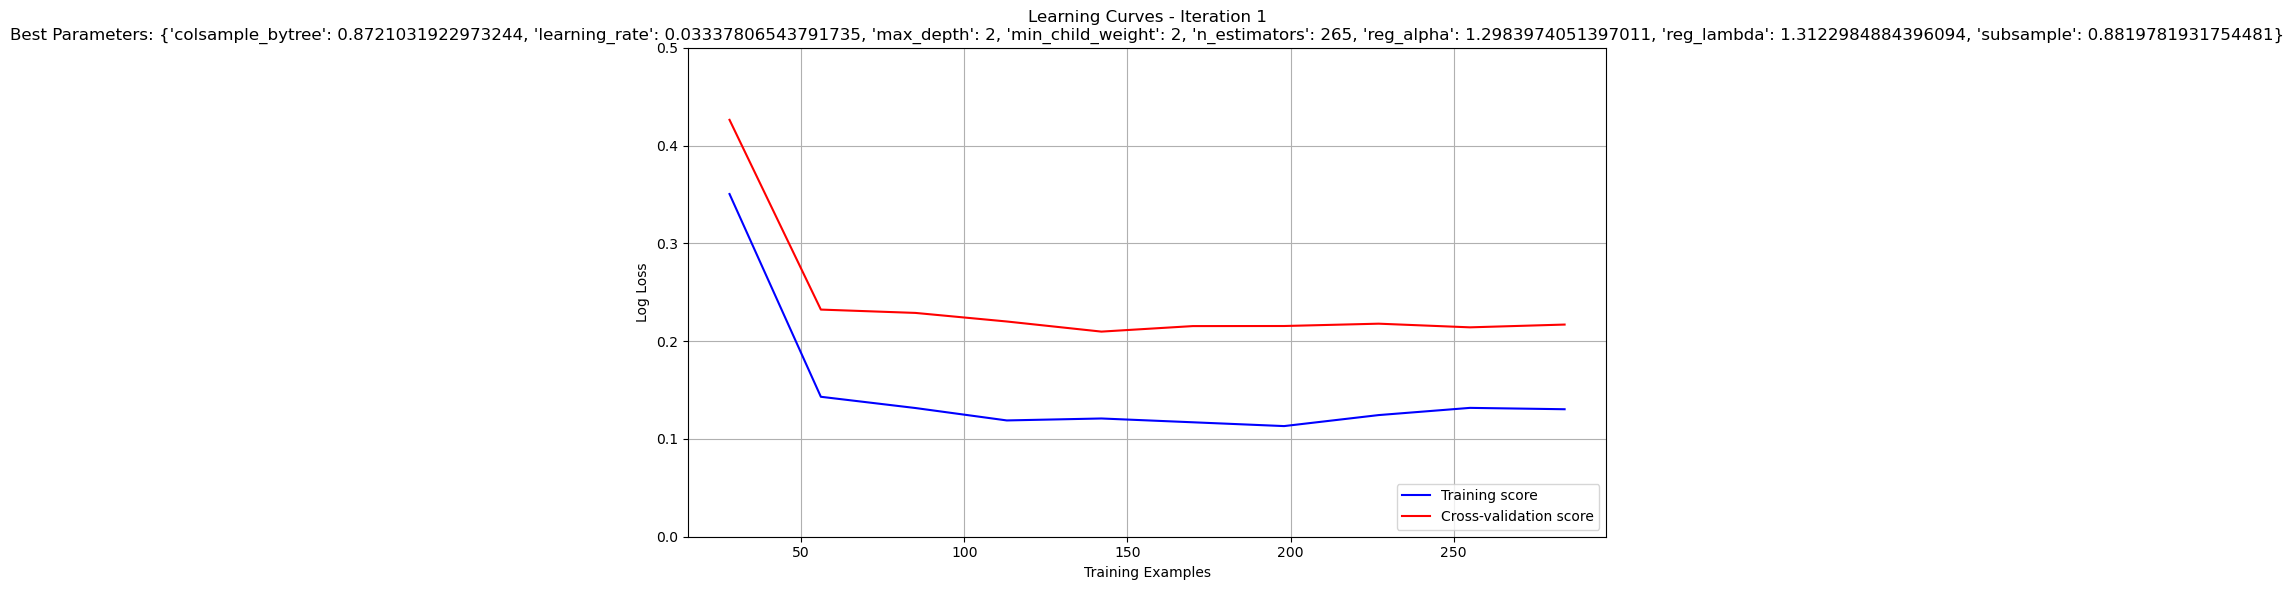


Precision Score:  0.6666666666666666
Recall Score:  0.5

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
355     Nico Hischier               48.0       1          1
218    Leon Draisaitl                5.0       1          1
312    Alex DeBrincat               13.0       1          1
179     Jake Guentzel               26.0       1          1
65       John Tavares               59.0       1          1
220  William Nylander                9.0       1          1

Missed Cltuch Players
              Player  clutch_score_rank  Actual  Predicted
421    Cole Caufield               39.0       1          0
371      Josh Norris               20.0       1          0
332    Tage Thompson               10.0       1          0
222     Nick Ritchie               58.0       1          0
313     Patrik Laine               12.0       1          0
113  Johnny Gaudreau               34.0       1          0



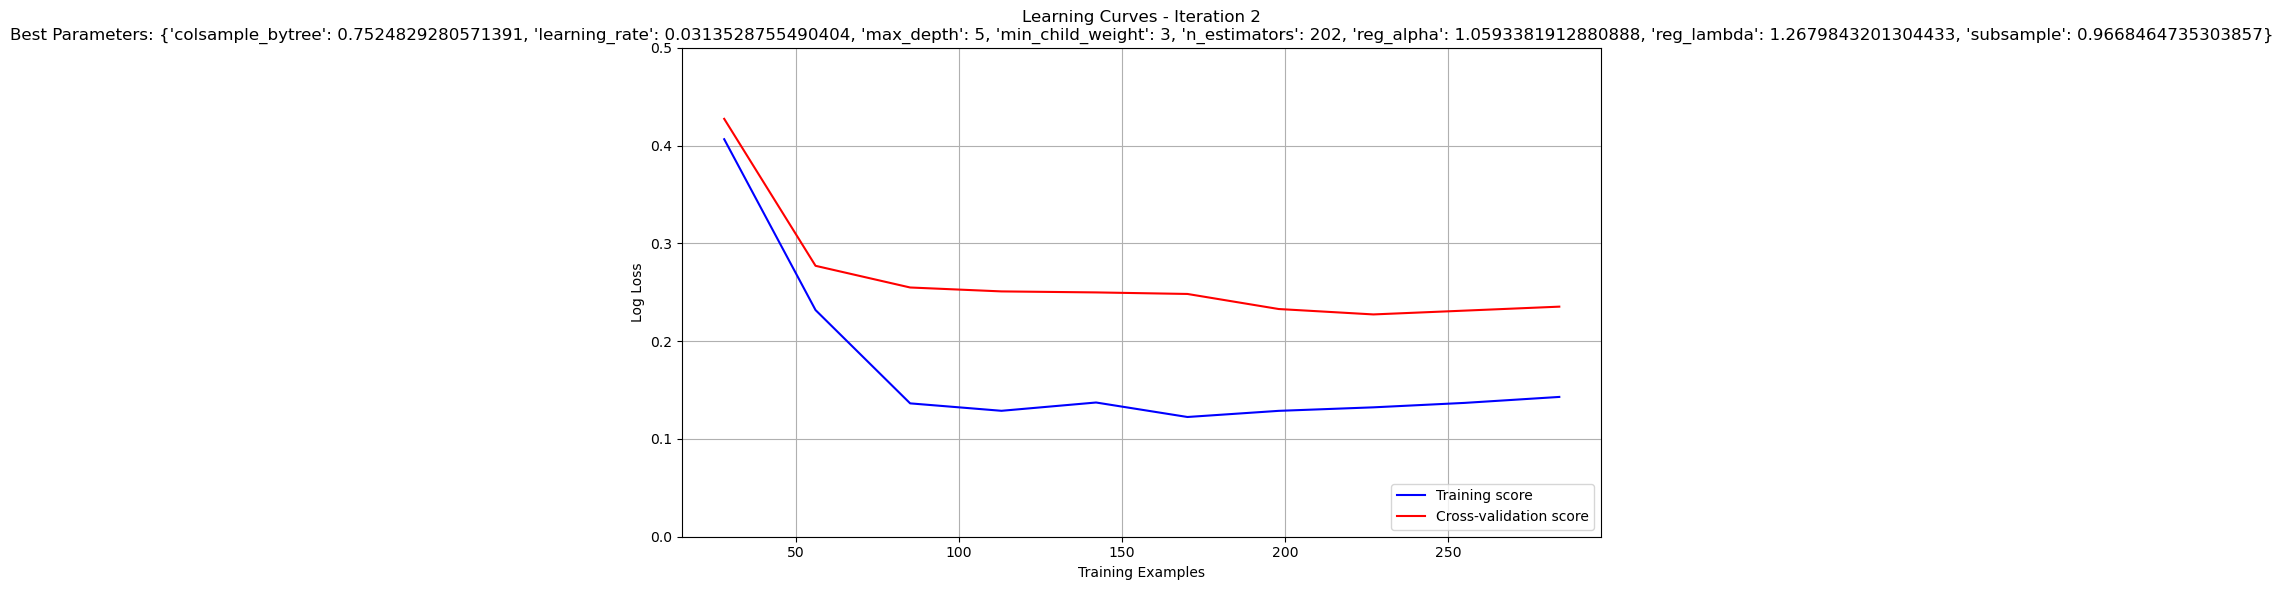


Precision Score:  0.6666666666666666
Recall Score:  0.6666666666666666

Correct Classfications
                Player  clutch_score_rank  Actual  Predicted
7     Patrice Bergeron               21.0       1          1
179      Jake Guentzel               26.0       1          1
128  Gabriel Landeskog                6.0       1          1
392      Brady Tkachuk               36.0       1          1
197   Nathan MacKinnon               27.0       1          1
265     Mikko Rantanen               18.0       1          1
65        John Tavares               59.0       1          1
202          Bo Horvat               32.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
332   Tage Thompson               10.0       1          0
131  Mika Zibanejad               22.0       1          0
10    Evgeni Malkin               53.0       1          0
277     Roope Hintz               19.0       1          0



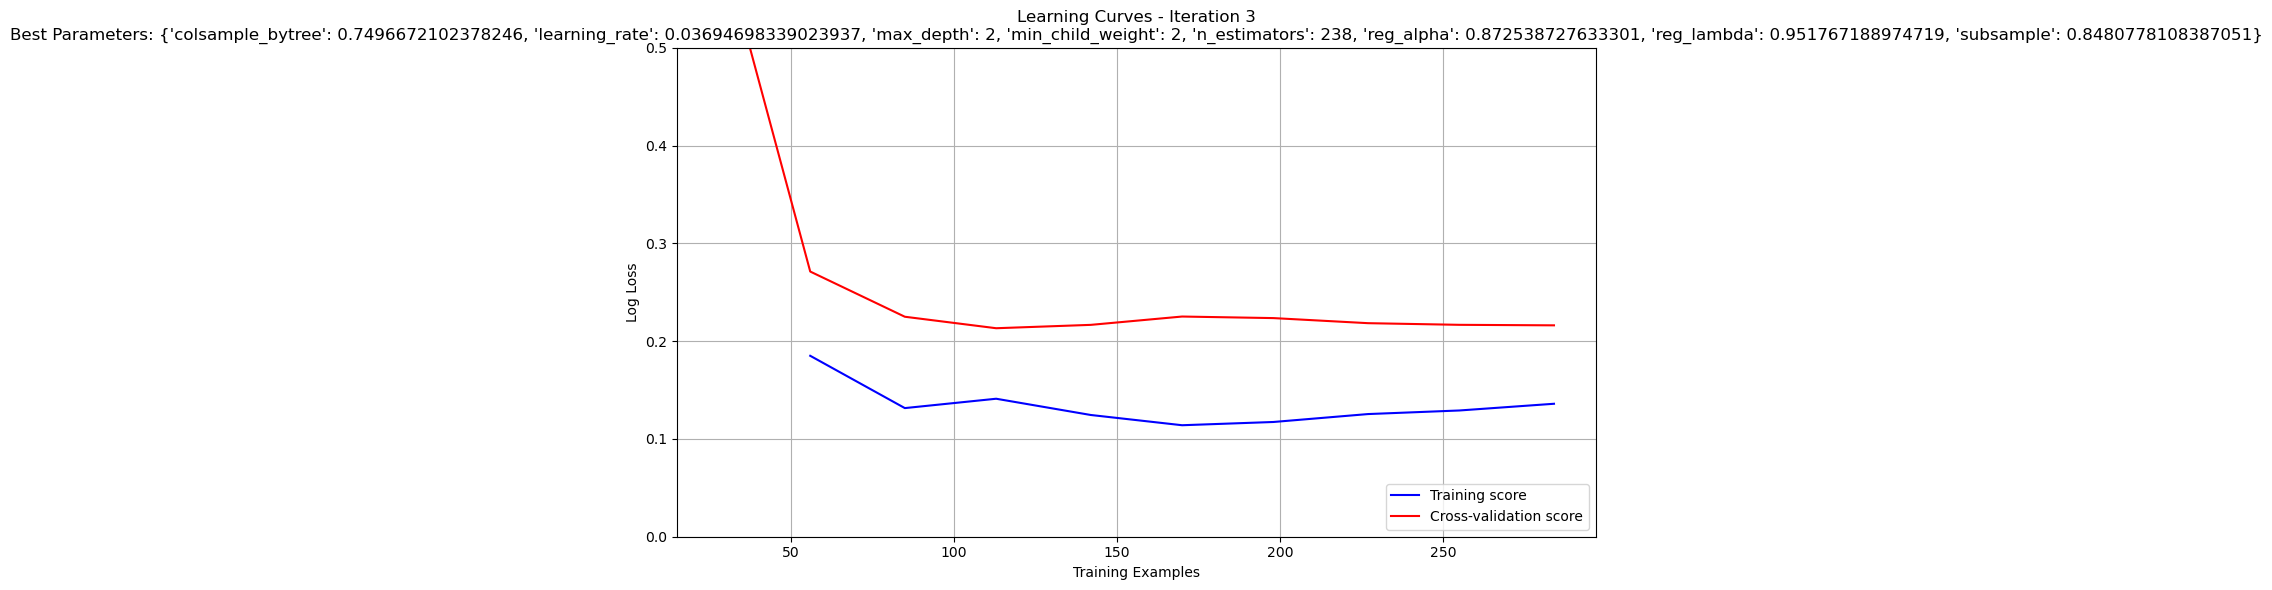


Precision Score:  0.6666666666666666
Recall Score:  0.6666666666666666

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
220  William Nylander                9.0       1          1
261    Connor McDavid                4.0       1          1
265    Mikko Rantanen               18.0       1          1
296   Kirill Kaprizov                3.0       1          1
9       Alex Ovechkin               24.0       1          1
392     Brady Tkachuk               36.0       1          1
71      Chris Kreider               30.0       1          1
241     Brayden Point               25.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
370    Martin Necas               51.0       1          0
221  Nikolaj Ehlers               41.0       1          0
10    Evgeni Malkin               53.0       1          0
298      Troy Terry               37.0       1          0



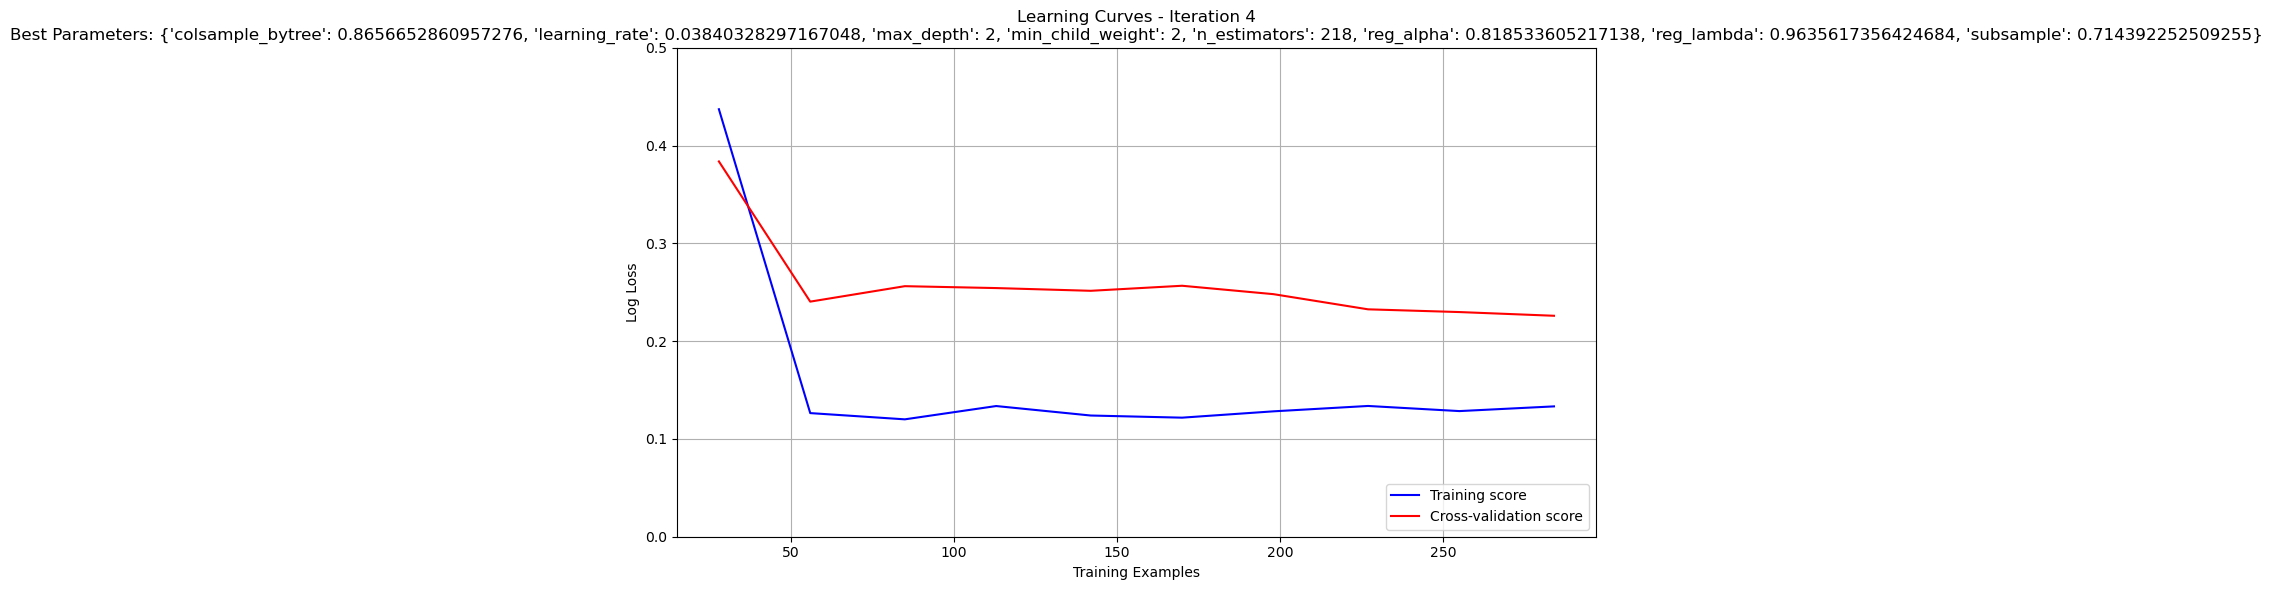


Precision Score:  0.8571428571428571
Recall Score:  0.5

Correct Classfications
              Player  clutch_score_rank  Actual  Predicted
264       Timo Meier               35.0       1          1
308  Auston Matthews                1.0       1          1
392    Brady Tkachuk               36.0       1          1
14     Sidney Crosby               40.0       1          1
202        Bo Horvat               32.0       1          1
355    Nico Hischier               48.0       1          1

Missed Cltuch Players
             Player  clutch_score_rank  Actual  Predicted
153  Filip Forsberg               17.0       1          0
277     Roope Hintz               19.0       1          0
332   Tage Thompson               10.0       1          0
222    Nick Ritchie               58.0       1          0
314  Clayton Keller               45.0       1          0
221  Nikolaj Ehlers               41.0       1          0



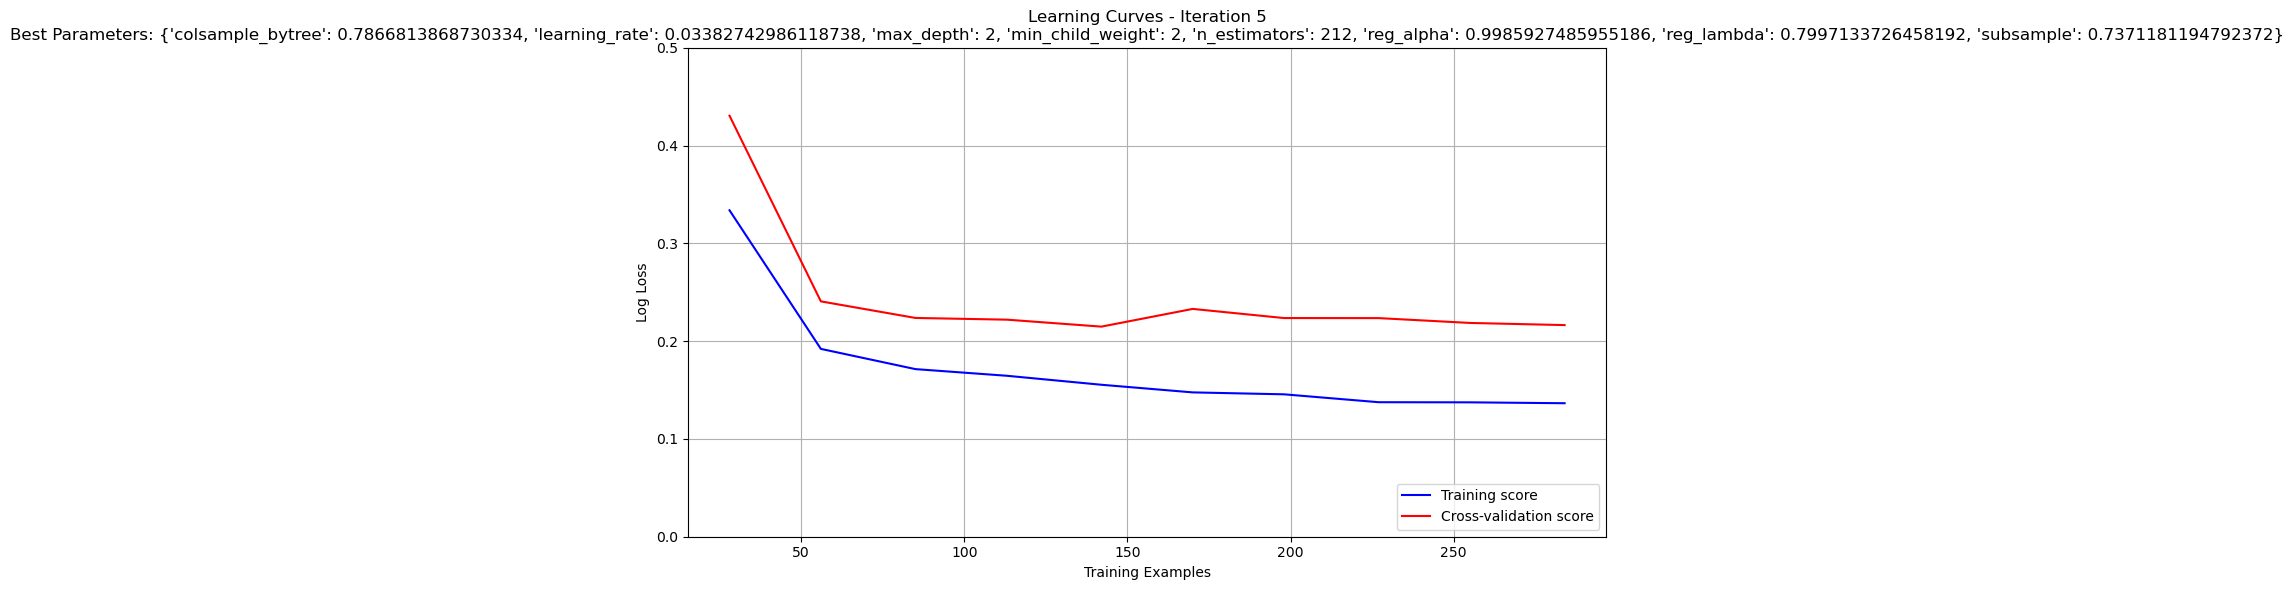


Precision Score:  0.6363636363636364
Recall Score:  0.5833333333333334

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
49     Steven Stamkos               15.0       1          1
296   Kirill Kaprizov                3.0       1          1
132    Mark Scheifele               28.0       1          1
7    Patrice Bergeron               21.0       1          1
308   Auston Matthews                1.0       1          1
218    Leon Draisaitl                5.0       1          1
225      Dylan Larkin               29.0       1          1

Missed Cltuch Players
            Player  clutch_score_rank  Actual  Predicted
421  Cole Caufield               39.0       1          0
332  Tage Thompson               10.0       1          0
313   Patrik Laine               12.0       1          0
222   Nick Ritchie               58.0       1          0
108     Mark Stone               60.0       1          0

Average Precision: 0.6987012987012987
Average Recall: 0.58

In [231]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a strong positive correlation with clutch score, which indicates that a linear regression model is suitable


In [851]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.838626
ixG_per_game                 0.832168
iFF_per_game                 0.844342
iSCF_per_game                0.854142
iHDCF_per_game               0.644151
assists_per_game             0.713333
iCF_per_game                 0.840431
rebounds_created_per_game    0.735829
time_on_ice_per_game         0.744669
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

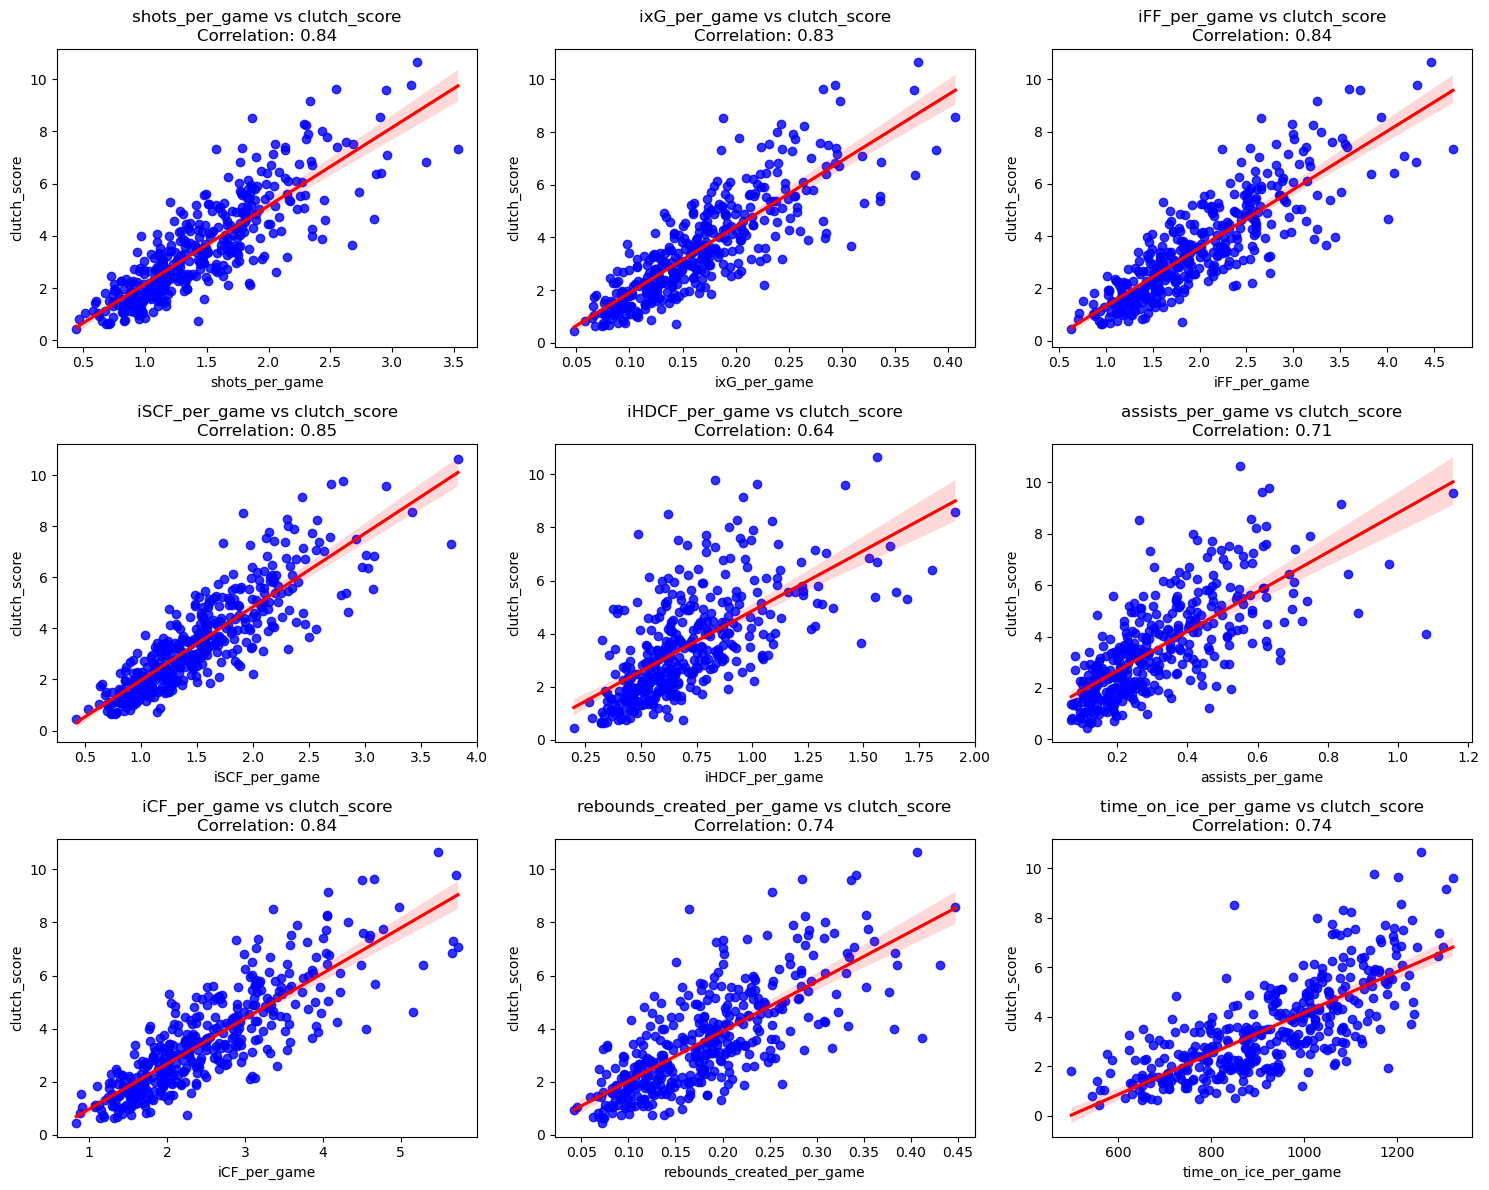

In [854]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 3, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Multicollinearity
Even though the features are highly correlated with each other, we should not expect any change in predictive performance because the correlations will exist in the test and training set. The model can still use the correlated features to make accurate predictions because the feature patterns learned during training will apply similarly in the test set.

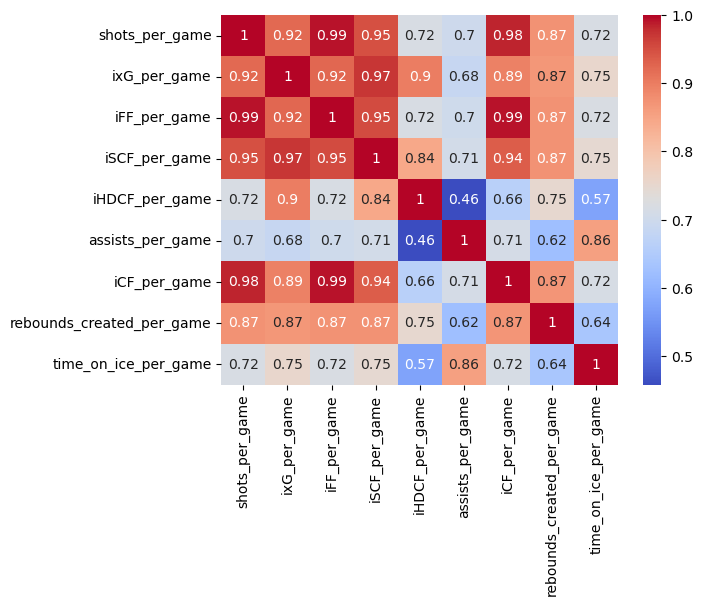

In [856]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

### Ridge Regression
Ridge Regression is a variant of linear regression that applies a penalty to the squared values of the coefficients in the regression equation. The penalty is controlled by the alpha parameter, which determines the strength of regularization. A higher value of alpha applies a stronger penalty which decreases the coefficients more. Unlike Lasso Regression, Ridge Regression does not set coefficients to zero and eliminate features. It instead keeps all features in the model but reduces the influence of less important features by shrinking their coefficients

Decreasing coefficients reduces the complexity of the model since the model will not become heavily reliant on certain features. It can instead focus on relevant features and generalize to unseen data.

We also must scale the data by setting the mean of each feature to 0 and standard deviation to 0, so that not one single feature dominates the model.
.


### Metrics
- MSE (Mean Squared Error): MSE measures the average squared difference between the predicted values and the actual values. Lower values indicate better model performance. It penalizes large errors more because the differences are squared.

- RMSE (Root Mean Squared Error): RMSE is the square root of MSE. It provides errors in the same units as the original data, making it easier to interpret. Like MSE, lower values are better, and it emphasizes larger errors due to squaring.

- Median  Error: Median of the absolute differences between predicted and actual values and is not skewed by large errors, unlike MSE and RMSE.
    
- R²: R² represents the proportion of the variance in the dependent variable (y) that is explained by the independent variable(s) (x) in the model. In other words, it shows how well the changes in x can explain or predict the changes in y. Values closer to 1 indicate that the model explains most of the variability in y, meaning a better fit, while values closer to 0 suggest that the model explains little of the variability in y, meaning a poorer fit. However, R^2 can be inflated by overfitting. As more predictors are features to the data, R^2 increases because the model can explain more variance in y, even if the features are not important.

- Adjusted R²: Adjusted R² adjusts R² for the number of predictors in the model. It accounts for overfitting by penalizing excessive use of unhelpful features. Like R², higher values are better.


In [861]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']

X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas = np.logspace(-3, 3, 20)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  0.8561248978909127
RMSE:  0.9252701756194851
Median Error:  0.5079460109160632
R²:  0.8229858024315839
Adjusted R²:  0.8207090924950127


### Learning Curves
It is important to evaluate the learning curves for ridge regression to determine if there is overfitting in the model. 

Although many of scikit-learn’s metrics are regarded as better when they return higher values, MSE is a loss function. Therefore, we take the negative value of MSE for the learning curve since higher positive values of MSE will yield more negative values.

### Interpreting the Graph


The MSE is multiplied by one, so the learning curve graph shows positive MSE and is easier to interpret (as smaller values of MSE are better).

The learning curves do not show significant overfitting. After approximately 250 samples, both training and validation curves converge to an MSE of less than 
2.
Thus, Ridge Regression is the correct choice for generalizing the training data.


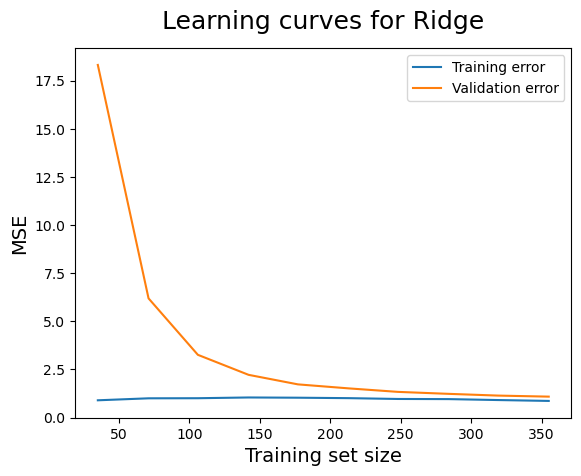

In [865]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

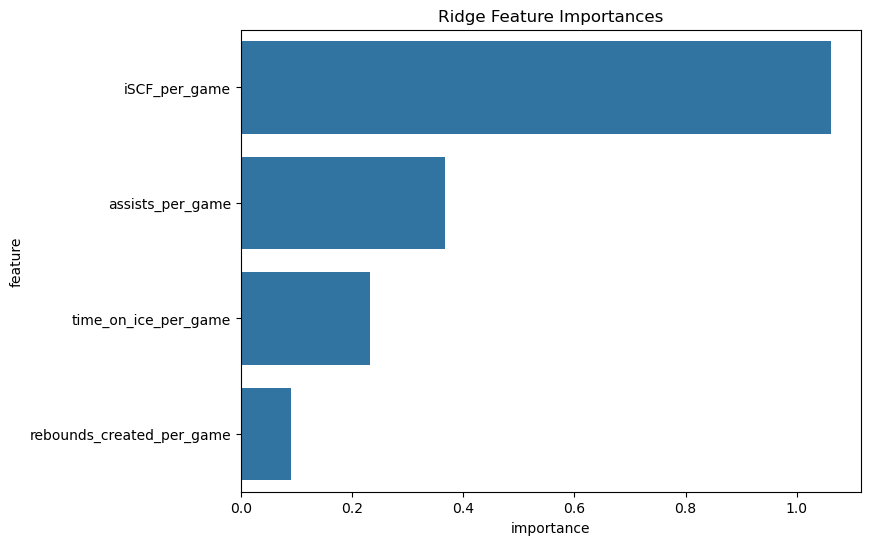

In [866]:
importances = abs(ridge_cv.coef_) 

fi = pd.DataFrame({
    "feature": x_var,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Ridge Feature Importances")
plt.show()


### Analyzing the Residuals
It is important to not just look at MSE and MAE, but also where the model is having issues with predicting the clutch scores of players.

From the dataframe below, it appears the model is underpredicting many elite players who excel in close and tied situations.

In [870]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(60))

All predictions and actual values:
                 Player  Actual  Predicted     Error
126     Nikita Kucherov    4.10   6.897588  2.797588
332       Tage Thompson    8.00   5.468870  2.531130
398   Andrei Svechnikov    3.98   6.253804  2.273804
43      Mikael Backlund    2.60   4.519623  1.919623
277         Roope Hintz    7.37   5.542747  1.827253
122        Brandon Saad    4.95   3.232193  1.717807
5          Ryan Getzlaf    2.12   3.823494  1.703494
20     Patric Hornqvist    3.66   5.334291  1.674291
308     Auston Matthews   10.64   9.018193  1.621807
222        Nick Ritchie    5.56   3.962552  1.597448
202           Bo Horvat    6.50   5.160525  1.339475
263     Jordan Greenway    1.30   2.636106  1.336106
53        Adam Henrique    5.18   3.880566  1.299434
134         J.T. Miller    4.61   5.757188  1.147188
35          Nick Bonino    3.64   2.516548  1.123452
287        Jake DeBrusk    5.11   4.002368  1.107632
164        Brock McGinn    3.40   2.316449  1.083551
0          

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

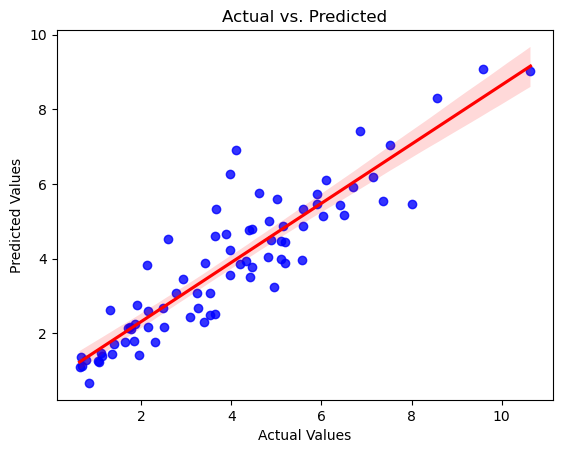

In [873]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

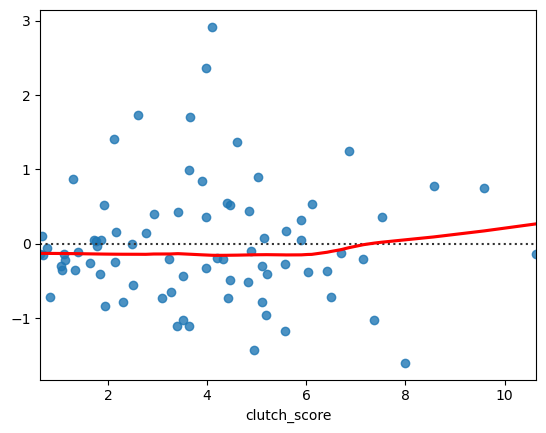

In [876]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

Cook's distance combines residuals (difference between the observed and predicted values) and leverage (how far away a data point is from the average of the predictor values) to determine the effect of the fit and predictions of a model when a data point is removed. A Cook's distance larger than the threshold (4 / n, with n being the number of observations) suggests that removing a particular data point would significantly change the model.

As shown below, the model tends to underestimate the performance of several elite players (e.g., McDavid and Matthews) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations.

Conversely, the model overestimates the performance of other elite players (e.g., Kucherov and both Tkachuks), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 29 influential points.
Outliers based on Cook's Distance:
                Player  Actual  Predicted  Cook's Distance
308    Auston Matthews   10.64   9.478178         0.019955
232     David Pastrnak    9.79   7.108157         0.030961
296    Kirill Kaprizov    9.64   6.972532         0.025170
218     Leon Draisaitl    9.16   6.860937         0.036282
224        Jakub Vrana    8.52   4.210314         0.067175
367    Jason Robertson    8.30   5.798892         0.040087
220   William Nylander    8.24   6.486381         0.010697
332      Tage Thompson    8.00   5.501506         0.016187
313       Patrik Laine    7.77   5.147858         0.043687
49      Steven Stamkos    7.53   5.511884         0.010656
371        Josh Norris    7.33   4.154112         0.023389
7     Patrice Bergeron    7.32   8.984083         0.058612
131     Mika Zibanejad    7.27   5.320820         0.011275
197   Nathan MacKinnon    6.84   8.393928         0.030334
65        John Tavares    5.56   7.485527      

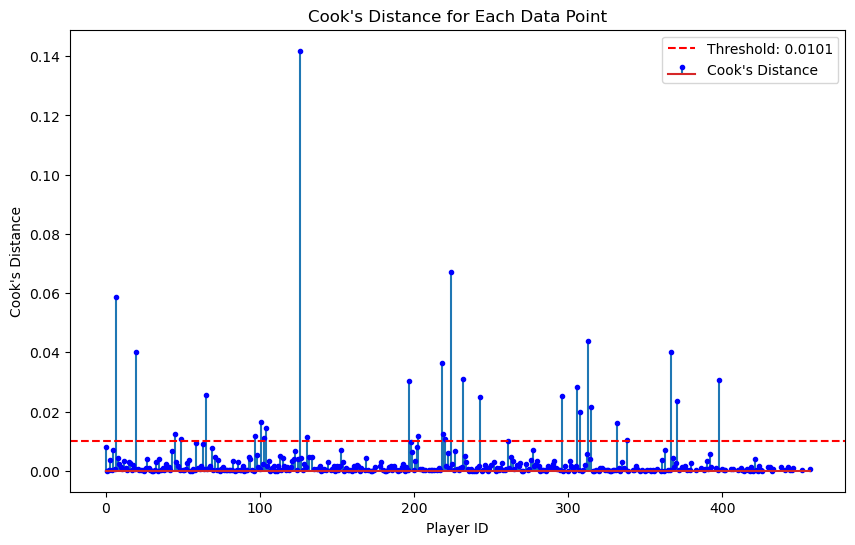

In [879]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


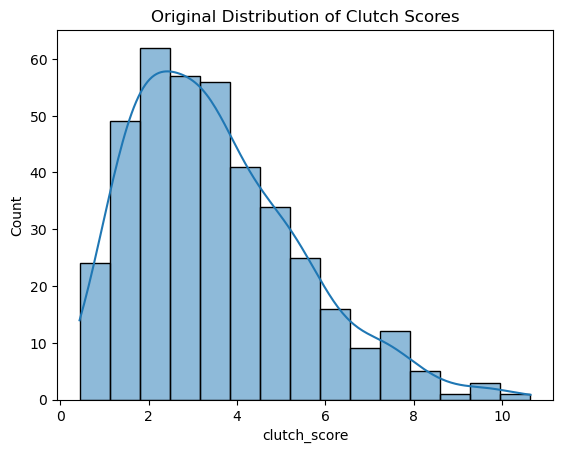

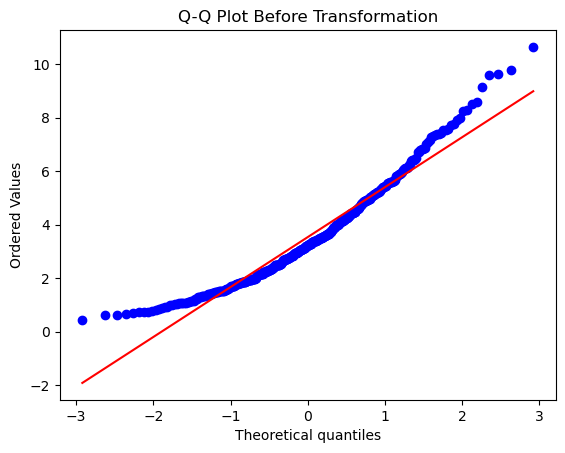

In [882]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Transforming the Data to a Normal Distribution with Log

As shown below, a log transformation is used to reduce the skew of the data and create a normal distribution. This ensures the predictions are not affected by the influential points we identified in Cook's distance.


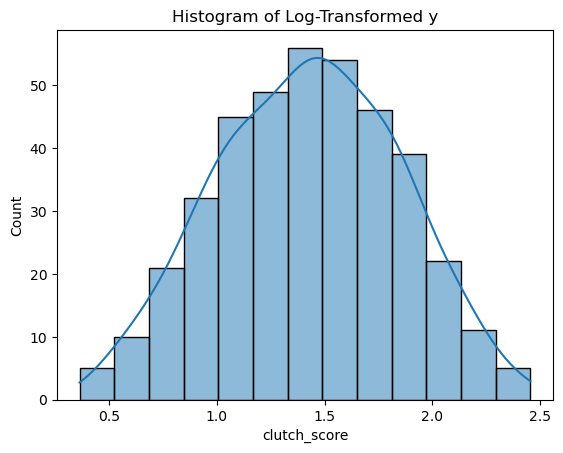

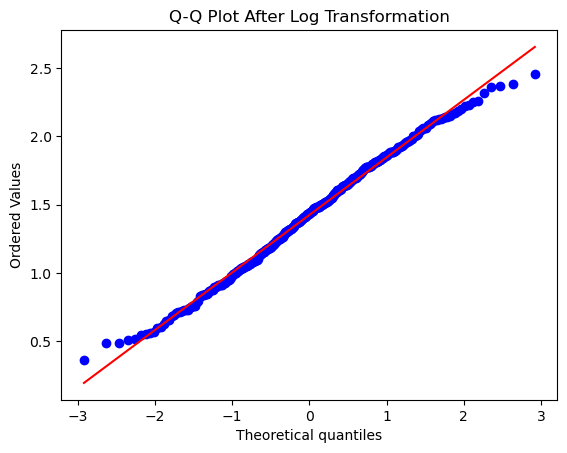

In [885]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

### Evaluating Metrics after the Log Transformation

After using a log transformation, it appears that the residuals have significantly decreased. However, it is important to remember the scale of the data has changed and we must look at the model's predictions of certain data points.

In [888]:
epsilon = np.abs(X_scaled.min()) + 1

X_shifted = X_scaled + epsilon

y_log = np.log(y + 1)

X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log, 
    y_log, 
    test_size=0.2, 
    random_state=200
)

alphas = np.logspace(-3, 3, 20)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
mae = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))


MSE:  0.04691894241311989
RMSE:  0.21660780783046554
MAE:  0.16530950565875036
R²:  0.7473899230732719
Adjusted R²:  0.7441409188684265


In [890]:
# After getting predictions in log space
y_pred_log = ridge_cv_log.predict(test_x)
r2_log = r2_score(test_y, y_pred_log)  # 0.69-0.73 probably

# Transform back to original scale
y_pred_original = np.exp(y_pred_log) - 1
test_y_original = np.exp(test_y) - 1

r2_original = r2_score(test_y_original, y_pred_original)
print(f"R² (log space): {r2_log:.4f}")
print(f"R² (original scale): {r2_original:.4f}")

R² (log space): 0.7474
R² (original scale): 0.7221


In [892]:
results = pd.DataFrame({'Player': merged_clutch_goals.loc[test_y.index, 'Player'], 'Actual': test_y, 'Predicted': y_pred})

results['Error'] = abs(results['Actual'] - results['Predicted'])
results.sort_values(by=['Error'], inplace = True, ascending = False)

print("All predictions and actual values:")
print(results.head(55))

All predictions and actual values:
                  Player    Actual  Predicted     Error
63         Alex Chiasson  1.766442   1.297136  0.469305
101      Mikael Granlund  1.078410   1.530240  0.451830
121          Victor Rask  1.560248   1.143785  0.416462
361      Gabriel Vilardi  1.838961   1.424531  0.414430
199      Jonathan Drouin  0.792993   1.198273  0.405280
338     Michael Pezzetta  1.040277   0.640904  0.399372
83        Calle Jarnkrok  1.719189   1.331014  0.388174
332        Tage Thompson  2.197225   1.848698  0.348527
313         Patrik Laine  2.171337   1.837134  0.334203
412       Logan O'Connor  0.912283   1.246177  0.333894
311      Carl Grundstrom  1.355835   1.027359  0.328477
164         Brock McGinn  1.481605   1.169879  0.311725
211       Ryan Carpenter  0.488580   0.794834  0.306254
370         Martin Necas  1.905088   1.605553  0.299535
227            Alex Tuch  1.442202   1.739953  0.297751
125     William Karlsson  1.381282   1.678851  0.297569
322          

### Calculating Cook's Distance 

After we apply the log transformation and calculate Cook's distance, we can see that the elite players are no longer influential points. However, there are some players which the model still struggles with. The model undervalues some players (e.g. Vrana, Kuzmenko) who may perform better in close and tied situations than their metrics suggest. On the other hand, some players are overvalued and may have better metrics that may not fully reflect their clutch performance (e.g. Kucherov, Kane). While influential points are often viewed negatively, they can provide valuable insights. These points could help NHL coaching staff and management identify players who perform well in high-pressure situations, even if they aren’t considered elite based on traditional metrics.

Finally, some below-average players become influential because the log transformation tends to amplify the difference between smaller actual and predicted values.


There are 24 influential points.
Outliers based on Cook's Distance:
                Player    Actual  Predicted  Cook's Distance
224        Jakub Vrana  2.253395   1.628517         0.028455
313       Patrik Laine  2.171337   1.813310         0.010616
371        Josh Norris  2.119863   1.592244         0.011614
306    Matthew Tkachuk  1.854734   2.154971         0.011073
63       Alex Chiasson  1.766442   1.366365         0.011368
59        Mike Hoffman  1.750937   1.294776         0.012144
126    Nikita Kucherov  1.629241   1.996914         0.037351
398  Andrei Svechnikov  1.605430   1.993290         0.013343
20    Patric Hornqvist  1.539015   1.839080         0.019602
0         Jason Spezza  1.508512   1.212010         0.014262
123      Brett Ritchie  1.446919   1.150712         0.020853
93       Austin Watson  1.302913   0.876279         0.013161
104     Joonas Donskoi  1.264127   1.632639         0.014670
234    Brendan Lemieux  1.184790   0.907370         0.010423
315   Jesse Pulju

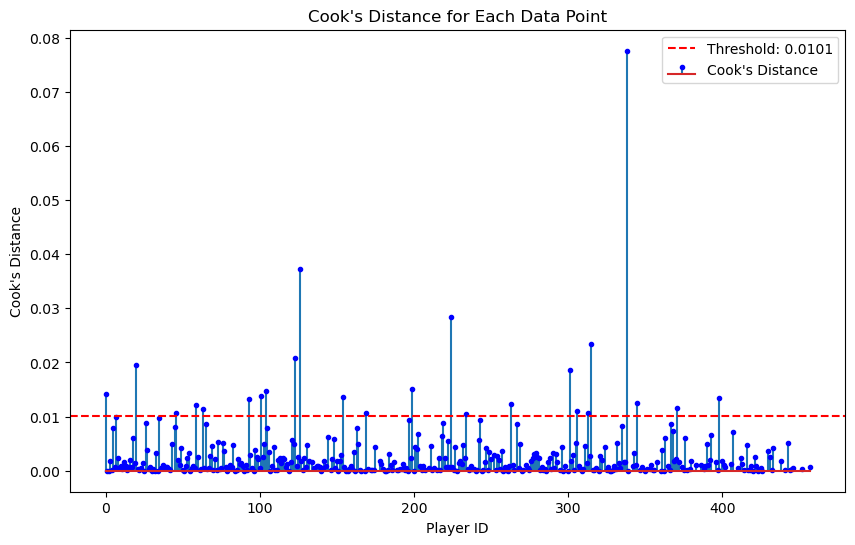

In [895]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_with_intercept)

outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

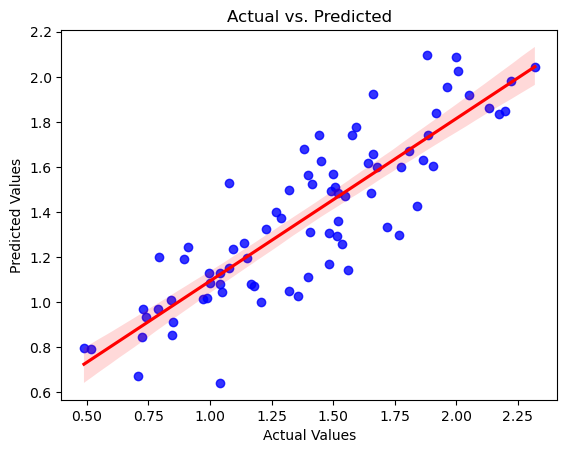

In [897]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2023-2024 season to the current 2024-2025 season).

In [900]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_log_loaded = joblib.load('ridge_cv_model.pkl')

In [902]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(epsilon, 'epsilon.pkl')

['epsilon.pkl']

In [904]:
all_seasons = []

for season in range(2024, 2026):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'goals': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
            'timeOnIcePerGame': 'mean',
            'teamAbbrevs': 'last'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2024-2025
Successfully fetched data for season 2025-2026
      playerId  skaterFullName positionCode  gamesPlayed  goals  assists  \
0      8470600      Ryan Suter            D           82      2       13   
1      8470613     Brent Burns            D          118     11       37   
2      8470621     Corey Perry            R          111     26       19   
3      8471214   Alex Ovechkin            L          102     58       46   
4      8471215   Evgeni Malkin            C           94     24       55   
...        ...             ...          ...          ...    ...      ...   
1003   8485483  Karsen Dorwart            L            5      0        0   
1004   8485493   David Tomasek            R           22      3        2   
1005   8485511    Quinn Hutson            R            5      1        0   
1006   8485512       Tim Washe            C            2      0        0   
1007   8485702    Max Shabanov            R           24      3       

In [905]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 40)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df.rename(columns={'timeOnIcePerGame': 'time_on_ice_per_game'}, inplace=True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [908]:
start_season = "20242025"
end_season = "20252026"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [910]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [911]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[(merged_natural_stat['GP'] >= 40)]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rebounds Created': 'rebounds_created'}, inplace=True)

In [912]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", ] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [914]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [918]:
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)

In [920]:
columns = ['ot_goals', 'regulation_game_winning', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'assists', 'rebounds_created']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [922]:
merged_clutch_goals_prediction['clutch_score'] = (
    0.4 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 
    0.4 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 
    0.2 * merged_clutch_goals_prediction['ot_goals_per_game']
)

In [924]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
149,Leon Draisaitl,15.96,1.0
391,Dylan Guenther,12.48,2.0
226,Alex DeBrincat,12.33,3.0
212,Kirill Kaprizov,12.15,4.0
253,Morgan Geekie,11.65,5.0
324,Cole Caufield,11.43,6.0
240,Tage Thompson,11.43,6.0
268,Josh Norris,11.21,8.0
27,John Tavares,11.17,9.0
136,Bo Horvat,11.15,10.0


In [926]:
merged_clutch_goals_prediction.fillna(0, inplace = True)
null_rows = merged_clutch_goals_prediction[merged_clutch_goals_prediction.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, goals, assists, ot_goals, game_winning_goals, time_on_ice_per_game, teamAbbrevs, regulation_game_winning, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rebounds_created, iCF, ot_goals_per_game, regulation_game_winning_per_game, goals_up_by_one_per_game, goals_down_by_one_per_game, goals_when_tied_per_game, shots_per_game, ixG_per_game, iFF_per_game, iSCF_per_game, iHDCF_per_game, iCF_per_game, assists_per_game, rebounds_created_per_game, clutch_score, clutch_score_rank]
Index: []

[0 rows x 37 columns]


In [928]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

In [930]:
scaler = joblib.load('scaler.pkl')
epsilon = joblib.load('epsilon.pkl')

X_scaled = scaler.transform(X_adjusted) 
X_scaled = np.nan_to_num(X_scaled, nan=0)

X_shifted = X_scaled + epsilon
X_log = np.log(X_shifted)

y_log = np.log(y + 1)
y_pred = ridge_cv_log_loaded.predict(X_log)

In [932]:
r2 = r2_score(y_log, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"Test Set Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Test Set Performance:
R²: 0.7038
RMSE: 3.7222
MAE: 2.8783


In [934]:
# Log-scale R² (model fit quality)
r2_log = r2_score(y_log, y_pred)  # 0.69

# Original-scale R² (practical performance)
y_pred_no_log = np.exp(y_pred) - 1
r2_original = r2_score(y, y_pred_no_log)  # 0.76

print(f"Model R² (log space): {r2_log:.4f}")
print(f"Prediction R² (clutch score): {r2_original:.4f}")

Model R² (log space): 0.7038
Prediction R² (clutch score): 0.6885


In [936]:
y_pred = ridge_cv_log_loaded.predict(X_log)
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 
merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 

In [938]:
merged_clutch_goals_prediction['log_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['log_adjusted'] = merged_clutch_goals_prediction['log_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

In [940]:
merged_clutch_goals_prediction[['Player', 'log_adjusted', 'predicted_clutch_score_adjusted']]

,Player,log_adjusted,predicted_clutch_score_adjusted
131,Nathan MacKinnon,23.41,25.25
181,Connor McDavid,21.97,24.79
224,Auston Matthews,23.80,24.60
329,Jack Hughes,24.09,24.29
212,Kirill Kaprizov,25.76,24.04
...,...,...,...
398,Zachary Bolduc,0.00,1.03
291,Isac Lundeström,0.00,0.43
107,Vincent Hinostroza,0.00,0.13
251,Zach Aston-Reese,0.00,0.11


In [942]:
from scipy import stats

y_pred_log = ridge_cv_log_loaded.predict(X_log)

train_residuals = train_y - ridge_cv_log_loaded.predict(train_x)
residual_std = np.std(train_residuals)

n = len(train_y)
p = train_x.shape[1]
df = n - p - 1

t_val = stats.t.ppf(0.95, df)
margin = t_val * residual_std

lower_log = y_pred_log - margin
upper_log = y_pred_log + margin

merged_clutch_goals_prediction['lower_bound_log'] = (lower_log * 10).round(2)
merged_clutch_goals_prediction['upper_bound_log'] = (upper_log * 10).round(2)
merged_clutch_goals_prediction['predicted_log_adjusted'] = (y_pred_log * 10).round(2)

merged_clutch_goals_prediction.loc[merged_clutch_goals_prediction['log_adjusted'] > 
    merged_clutch_goals_prediction['upper_bound_log'], 'Significantly_Clutch'] = True 

In [944]:
merged_clutch_goals_prediction = merged_clutch_goals_prediction.loc[merged_clutch_goals_prediction['goals'] >= 20]

In [946]:
import shap

explainer = shap.LinearExplainer(ridge_cv_log_loaded, X_log)
shap_values = explainer(X_log)

In [948]:
shap_df = pd.DataFrame(
    shap_values.values,     
    columns=X_adjusted.columns,  # Use original DataFrame
    index=X_adjusted.index
)

# Add SHAP values as new columns
for col in shap_df.columns:
    merged_clutch_goals_prediction[f'shap_{col}'] = shap_df[col]

In [950]:
merged_clutch_goals_prediction

,playerId,Player,positionCode,gamesPlayed,goals,assists,ot_goals,game_winning_goals,time_on_ice_per_game,teamAbbrevs,...,log_adjusted,predicted_clutch_score_adjusted,lower_bound_log,upper_bound_log,predicted_log_adjusted,Significantly_Clutch,shap_iSCF_per_game,shap_assists_per_game,shap_rebounds_created_per_game,shap_time_on_ice_per_game
131,8477492,Nathan MacKinnon,C,115,62,115,2,9,1342.93295,COL,...,23.41,25.25,19.29,25.88,22.59,NaN,0.499241,0.200818,0.110254,0.128648
181,8478402,Connor McDavid,C,105,49,118,0,4,1339.34810,EDM,...,21.97,24.79,17.35,23.94,20.64,NaN,0.427817,0.223783,0.113486,0.127898
224,8479318,Auston Matthews,C,98,47,54,2,4,1239.19640,TOR,...,23.80,24.60,18.40,24.99,21.70,NaN,0.557338,0.093876,0.117200,0.105803
329,8481559,Jack Hughes,C,81,38,53,3,9,1260.02415,NJD,...,24.09,24.29,20.75,27.34,24.04,NaN,0.468304,0.122791,0.141039,0.110592
212,8478864,Kirill Kaprizov,L,79,47,52,4,7,1341.95950,MIN,...,25.76,24.04,15.09,21.68,18.39,True,0.446190,0.123822,0.119883,0.128445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,8479339,Patrik Laine,L,57,20,14,1,5,807.42115,MTL,...,21.25,13.23,10.03,16.62,13.32,True,-0.215288,-0.018299,0.001261,-0.030217
308,8481032,Paul Cotter,L,116,21,11,0,3,765.41565,NJD,...,13.24,12.70,11.27,17.86,14.56,NaN,-0.144900,-0.099899,-0.021280,-0.049631
214,8478874,Adam Gaudette,R,112,27,11,0,6,674.59215,SJS,...,20.06,12.59,10.48,17.07,13.77,True,-0.108873,-0.097745,-0.021280,-0.098895
146,8477919,Freddy Gaudreau,C,104,21,24,0,2,940.23390,SEA,...,0.00,1.60,-3.16,3.43,0.13,NaN,-1.165386,-0.025259,-0.256438,0.021568


In [952]:
merged_clutch_goals_prediction.to_csv("clutch.csv")

In [ ]:
merged_clutch_goals_prediction['residual'] = y - y_pred
top_clutch = merged_clutch_goals_prediction.nlargest(20, 'residual')
print(top_clutch[['Player', 'clutch_score', 'predicted_clutch_score', 'residual']])

### Making the Results Interpretable

To make the results more interpretable, I have made the following changes:
- Player's predicted and clutch score multiplied by 10
- A tier for the player based on how far they are from the mean for clutch score
- A percentage difference between their actual and predicted values
- A classification for the percentage diff

The results will be saved in an Excel file: "Player Clutch Statisticserence


In [115]:
def create_clutch_rankings(df):

    def assign_tier(z_score):
        if z_score >= 2:
            return 'Franchise'
        elif z_score >= 1.5:
            return 'Elite'
        elif z_score >= 1:
            return 'Above Average'
        elif z_score > -1:
            return 'Below Average'
        else:
            return 'Limited Clutch Impact'

    rankings = df.copy()
    mean_score = rankings['log_adjusted'].mean()
    std_score = rankings['log_adjusted'].std()
    rankings['standard_deviations'] = (rankings['log_adjusted'] - mean_score) / std_score
    
    rankings['tier'] = rankings['standard_deviations'].apply(assign_tier)
    
    rankings['vs_predicted'] = ((rankings['log_adjusted'] - rankings['predicted_clutch_score_adjusted']) / rankings['predicted_clutch_score_adjusted'] * 100).round(2)
    rankings['vs_predicted'] = rankings['vs_predicted'].apply(lambda x: f"+{x}%" if x > 0 else f"{x}%")
            
    def get_prediction_reliability(diff):
        diff_num = float(diff.rstrip('%'))
        if diff_num >= 0:
            if  diff_num <= 10:
                return 'Slightly Overperforming'
            elif diff_num <= 20:
                return 'Overperforming'   
            else:
                return 'Heavily Overperforming'
        elif diff_num <= 0:
            if  diff_num >= -10:
                return 'Slightly Underperforming'
            elif diff_num >= -20:
                return 'Underperforming'   
            else:
                return 'Heavily Underperforming'   

    
    rankings['Prediction Reliability'] = rankings['vs_predicted'].apply(get_prediction_reliability)
    
    output = rankings[[
        'Player',
        'predicted_clutch_score_adjusted',
        'log_adjusted',
        'tier',
        'vs_predicted',
        'Prediction Reliability'
    ]].sort_values('log_adjusted', ascending=False)
    
    output = output.reset_index(drop=True)
    output.index = output.index + 1
    
    output.columns = ['Player', 'Predicted Clutch Score', 'Actual Clutch Score', 'Tier', 'Predicted VS Actual', 'Reliability']

    output.to_excel("C:\\Users\\Work\\Desktop\\clutch.xlsx")
    
    return output.to_dict(orient='records')

### Cook's Distance Observations

The model shows the same patterns as before - it undervalues and overvalues some players. A few differences are also amplified by the log transformation.

In [117]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)

outliers = np.where(cooks_d > threshold)[0]

merged_clutch_goals_prediction = merged_clutch_goals_prediction.reset_index()

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction.loc[y.index, 'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.iloc[outliers]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

KeyError: '[391, 226, 253, 324, 240, 268, 289, 265, 329, 359, 224, 431, 375, 243, 257, 399, 234, 261, 409, 263, 427, 328, 364, 425, 302, 227, 284, 408, 389, 336, 430, 345, 267, 355, 356, 342, 228, 338, 334, 404, 429, 217, 374, 306, 373, 396, 294, 276, 377, 262, 335, 428, 322, 354, 264, 401, 414, 277, 357, 388, 266, 305, 417, 433, 380, 222, 246, 230, 363, 299, 424, 412, 283, 331, 319, 387, 339, 288, 325, 384, 259, 366, 420, 260, 383, 418, 386, 385, 405, 275, 237, 361, 285, 353, 238, 258, 421, 242, 326, 256, 411, 333, 344, 272, 360, 300, 225, 350, 372, 320, 352, 369, 419, 390, 365, 290, 245, 332, 235, 315, 413, 249, 311, 394, 358, 330, 434, 269, 376, 378, 223, 308, 248, 247, 347, 395, 255, 393, 323, 343, 403, 232, 313, 244, 250, 392, 426, 340, 293, 229, 303, 241, 337, 280, 321, 316, 252, 274, 295, 270, 254, 379, 309, 318, 287, 281, 362, 370, 271, 400, 432, 348, 286, 351, 407, 402, 282, 415, 220, 349, 304, 422, 310, 273, 346, 296, 314, 218, 221, 307, 397, 317, 327, 231, 236, 239, 416, 312, 423, 368, 279, 341, 298, 382, 410, 297, 233, 406, 219, 278, 367, 381, 371, 301, 251, 291, 292, 398] not in index'

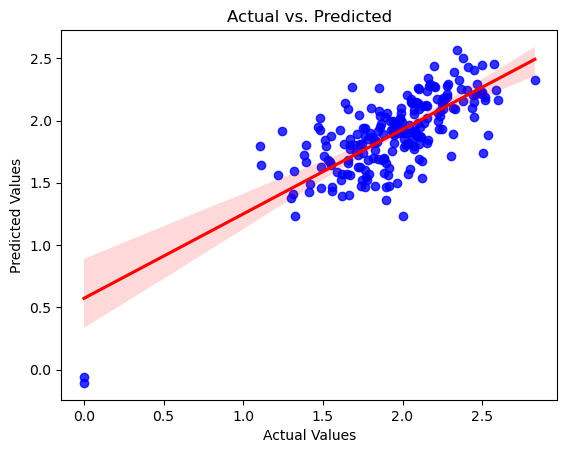

In [361]:
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log'], y=merged_clutch_goals_prediction['predicted_clutch_score'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Concluding Thoughts
Through this project, I hope that I have built a well-tuned regression model that is able to perform well in predicting the clutch score of NHL players. Although Cook's distance did identify some influential points in the final model, these points may be useful in determining overvalued and undervalued players.

I hope to and connect the model to a PowerBI dashboard to provide real-time updates on the clutch performance of players.

In [372]:
correlation_matrix = train_x.corr()
high_corr = correlation_matrix[abs(correlation_matrix) > 0.8].stack().drop_duplicates()
print(high_corr)

AttributeError: 'numpy.ndarray' object has no attribute 'corr'